# Noisy Networks for Exploration

Noisy Networks are a means for encouraging exploration through learning perturbations of the network weights that drive exploration.

NoisyNet is an alternative to $\epsilon$-greedy methods for exploration.

# Imports & Constants

In [9]:
import sys
import os

# Assuming the notebook is located inside `subfolder` and
# we want to import a module in `parent_folder`

# Get the absolute path to the 'subfolder'.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Calculate the path to the 'parent_folder' by going one level up.
parent_dir = os.path.dirname(notebook_dir)

# Add the 'parent_folder' to sys.path if it is not already there.
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [10]:
import os
import math
import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
from typing import Dict, List, Tuple

from buffers import ReplayBuffer
from agents import BaseDQNAgent, MlpDQNAgent

# Noisy Layer

In [11]:
class NoisyLinear(nn.Module):
    """
    Class representing a Noisy Linear Module for Noisy Networks.
    """

    def __init__(self, in_features: int, out_features: int, std_init: float = 0.5):
        """
        Instantiates a NoisyLinear Module.
        """
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer(
            "bias_epsilon", torch.Tensor(out_features)
        )

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """
        Resets all trainable network parameters (i.e., Factorised Gaussian Noise).
        """
        mu_range = 1 / math.sqrt(self.in_features)

        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )

        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """
        Makes new noise.
        """
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # Perform the outer product.
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass of the layer.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """
        Sets the scale to make noise acrosss. Specifically, Factorised Gaussian Noise.
        """
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

# Noisy Network

In [12]:
class NoisyNetwork(nn.Module):
    """
    Class representing a Noisy Neural Network for exploration.
    """

    def __init__(self, in_dim: int, out_dim: int):
        """
        Instantiates a NoisyNetwork.
        """
        super().__init__()

        self.features = nn.Linear(in_dim, 128)
        self.noisy_layer1 = NoisyLinear(128, 128)
        self.noisy_layer2 = NoisyLinear(128, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass of the neural network.
        """
        features = F.relu(self.features(x))
        hidden = F.relu(self.noisy_layer1(features))

        return self.noisy_layer2(hidden)
    
    def reset_noise(self):
        """
        Resets all noisy layers.
        """
        self.noisy_layer1.reset_noise()
        self.noisy_layer2.reset_noise()

# Noisy Network DQN Agent

In [13]:
class NoisyDQNAgent(MlpDQNAgent):

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        seed: int,
        gamma: float = 0.99,
    ):
        super().__init__(
            env, 
            memory_size, 
            batch_size, 
            target_update, 
            seed=seed, 
            gamma=gamma
        )
        # Noisy DQN Networks.
        obs_dim = np.prod(self.obs_shape)
        self.dqn = NoisyNetwork(obs_dim, self.action_dim).to(self.device)
        self.dqn_target = NoisyNetwork(obs_dim, self.action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # Optimiser
        self.optimiser = optim.Adam(self.dqn.parameters())

    def select_action(self, state: np.ndarray, determinstic: bool = False) -> np.ndarray:
        # As we are using noisy networks, we do not use an epsilon-greedy policy for
        # action selection.
        flattened_state = state.flatten()

        selected_action = self.dqn(
            torch.Tensor(flattened_state).to(self.device)
        ).argmax()
        selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action
    
    def update_model(self) -> torch.Tensor:
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        # Reset the noise in the noisy network layers.
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()

# Train an agent

In [14]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")

In [19]:
seed = 777
num_frames = 100_000
memory_size = 4_000
gamma = 0.8
batch_size = 64
target_update = 50

agent = NoisyDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    seed,
    gamma = gamma
)

cuda


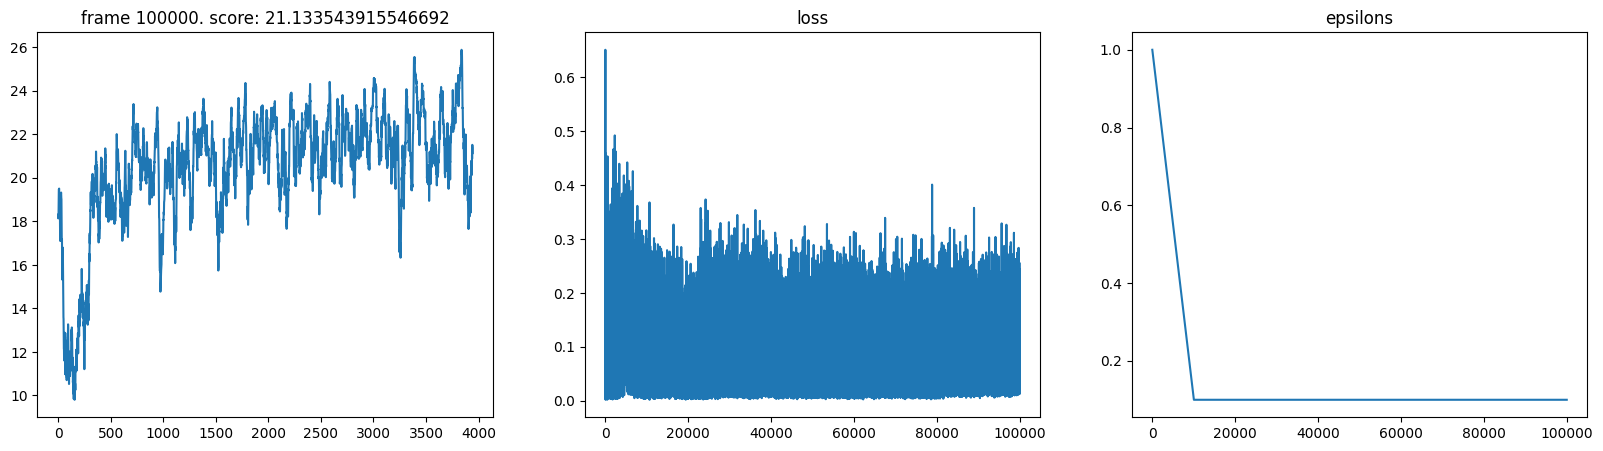

In [20]:
agent.train(num_frames)

# Test the agent

In [ ]:
ep_lens, ep_rews = agent.test(100, frame_interval=0)